<a href="https://colab.research.google.com/github/khbae/trading/blob/master/08_Regression_GARCH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regressions with GARCH residuals

**Source**
- https://stats.stackexchange.com/questions/93815/fit-a-garch-1-1-model-with-covariates-in-r <br>
- http://www.rimini.unibo.it/fanelli/EViews_Lab.pdf
- https://cran.r-project.org/web/packages/rugarch/rugarch.pdf
<br><br>

Volatility varies and clusters over time as it is likely to be high during financial crisis periods and is likely to be low for other periods. This pattern is called **volatility clustering**. Furthermore, volatility seems to react differently to a big price increase or a bif price drop, referred to as the **leverage effect**. 

![alt text](http://www.cboe.com/publish/micrositecharts/VIX_SP500_Index.jpg "VIX and S&P500 Index")
<br><br>
Assume the following regression model:

$$y_{t}=\text{intercept} + \lambda_0 x_{t,0} + \lambda_1 x_{t,1} + \varepsilon_{t} $$

$$ \varepsilon_{t} = \sigma_t Z_t $$

$$ \sigma_{t}^{2} = \omega + \alpha  \varepsilon_{t-1}^{2} + \beta \sigma_{t-1}^{2} $$

Note that $x_{t,1}$ and $x_{t,2}$ are external covariates (i.e. independent variables), and residuals ($\varepsilon_{t}$) are modelled as **GARCH(1,1)**.  $Z_t$ be a white noise.

We are going to randomly choose $x_{t,1}$, $x_{t,2}$ and $\varepsilon_{t}$. Then create $y_t$ from the random samples.

In [0]:
!pip install Cython
!pip install arch

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
import statsmodels.formula.api as sm

## Regression Model:

$$y_{t}=\text{intercept} + \lambda_0 x_{t,0} + \lambda_1 x_{t,1} + \varepsilon_{t} $$

$$ \varepsilon_{t} = \sigma_t Z_t $$

$$ \sigma_{t}^{2} = \omega + \alpha  \varepsilon_{t-1}^{2} + \beta \sigma_{t-1}^{2} $$

In [0]:
# Parameter Setups
T = 252*10 # about 10 years of trading days.

intercept = 0.1
lambda0 = 0.2
lambda1 = 0.3

omega = 0.4
alpha1 = 0.5
beta1 = 0.6

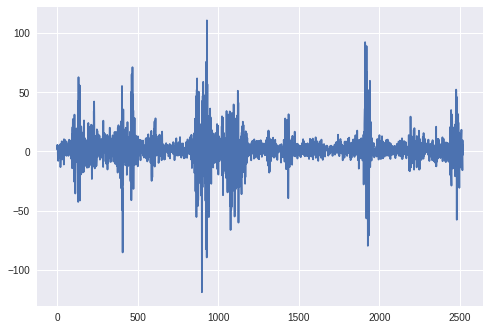

In [0]:
## Create Exogenous Covariates;
x0 = np.random.normal(2,1,T)
x1 = np.random.normal(4,10,T)

# Simulate Garch
esp = np.zeros(T)
sigma = np.zeros(T)
zt = np.random.normal(0,1,T)

for t in range(T):
  sigma[t] = np.sqrt(omega + alpha1 * esp[t-1]**2 + beta1*sigma[t-1]**2)
  esp[t] = sigma[t] * zt[t]

ysim = intercept + lambda0 * x0 + lambda1 * x1 + esp
plt.plot(ysim)

In [0]:
# Regression with GARCH
regout = arch_model(y=ysim,x=np.c_[x0,x1],mean='LS',vol='Garch').fit()

Iteration:      1,   Func. Count:      8,   Neg. LLF: 8442.568976212999
Iteration:      2,   Func. Count:     20,   Neg. LLF: 8438.93935961949
Iteration:      3,   Func. Count:     30,   Neg. LLF: 8422.955813576109
Iteration:      4,   Func. Count:     39,   Neg. LLF: 8366.06599990511
Iteration:      5,   Func. Count:     48,   Neg. LLF: 8289.349343334952
Iteration:      6,   Func. Count:     57,   Neg. LLF: 8260.5257483405
Iteration:      7,   Func. Count:     67,   Neg. LLF: 8254.272220444234
Iteration:      8,   Func. Count:     76,   Neg. LLF: 8156.343115015168
Iteration:      9,   Func. Count:     85,   Neg. LLF: 8112.175329954554
Iteration:     10,   Func. Count:     94,   Neg. LLF: 8101.795382618191
Iteration:     11,   Func. Count:    102,   Neg. LLF: 8096.3755405760785
Iteration:     12,   Func. Count:    110,   Neg. LLF: 8088.0426900156135
Iteration:     13,   Func. Count:    118,   Neg. LLF: 8087.490975564113
Iteration:     14,   Func. Count:    127,   Neg. LLF: 8087.4219140

In [0]:
print(regout.summary())

                     Least Squares - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.040
Mean Model:             Least Squares   Adj. R-squared:                  0.039
Vol Model:                      GARCH   Log-Likelihood:               -8087.41
Distribution:                  Normal   AIC:                           16186.8
Method:            Maximum Likelihood   BIC:                           16221.8
                                        No. Observations:                 2520
Date:                Wed, Feb 21 2018   Df Residuals:                     2514
Time:                        04:07:56   Df Model:                            6
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
Const          0.2431      0.122      1.991  4.649e-02 [3.774e-0

### A Mean Model (arch.mean)
* Zero mean (ZeroMean) - useful if using residuals from a model estimated separately
* Constant mean (Constant Mean) - common for most liquid financial assets
* Exogenous regressors only (LS)
* Autoregressive (ARX) with optional exogenous regressors
* Heterogeneous (HARX) autoregression with optional exogenous regressors


In [0]:
## OLS regression
dat2 = pd.DataFrame(data=np.c_[x0,x1,ysim],columns=['x0','x1','ysim'])
dat2.head()
olsreg = sm.ols(formula='ysim~x0+x1',data=dat2).fit()
print(olsreg.summary())


                            OLS Regression Results                            
Dep. Variable:                   ysim   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     53.55
Date:                Wed, 21 Feb 2018   Prob (F-statistic):           1.67e-23
Time:                        04:11:22   Log-Likelihood:                -10168.
No. Observations:                2520   AIC:                         2.034e+04
Df Residuals:                    2517   BIC:                         2.036e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0019      0.626      0.003      0.9

In [0]:
## Newey-West method, cov_type='HAC', cov_kwds={'maxlags':10}
dat2 = pd.DataFrame(data=np.c_[x0,x1,ysim],columns=['x0','x1','ysim'])
dat2.head()
nwreg = sm.ols(formula='ysim~x0+x1',data=dat2).fit(cov_type='HAC', cov_kwds={'maxlags':10})
print(nwreg.summary())

                            OLS Regression Results                            
Dep. Variable:                   ysim   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     79.03
Date:                Wed, 21 Feb 2018   Prob (F-statistic):           5.16e-34
Time:                        04:12:24   Log-Likelihood:                -10168.
No. Observations:                2520   AIC:                         2.034e+04
Df Residuals:                    2517   BIC:                         2.036e+04
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0019      0.552      0.003      0.9